# Developing a Spatial Memory for an Agent

Our goal is to build an agent that can infer space as a consequence of how its actions affect its sensor data. The space that we will infer is a kind of map of what the agent should expect to observe with its sensors in each place. That is, we want a spatial memory that maps locations to expected sensor data. This is our first goal.

In the spirit of the [Tolman Eichenbaum Machine](https://www.sciencedirect.com/science/article/pii/S009286742031388X) of Whittington _et al._, our agent will learn the space for this spatial memory through a variational autoencoder, that is to say, through a harmonic process that aligns the sensor data that is read from the memory with the locations that are inferred from the senses.

As a consequence, our spatial memory must be invertible; given the current sensor observations, the memory should provide one or more guesses for the correct location. We will model this as a sampling procedure over the memory contents. 

Once our memory is invertible, we can use it for other purposes. For instance, if we can classify sensor data according to whether or not it satisfies the agent's needs (_e.g._ water or food), then we can search the memory for locations where these needs can be satisfied. Ideally, these locations will be close to the present position of the agent, so we want our search to be conditioned on the agent's position. We will represent this as taking a conditional sample.

Furthermore, the efficiency of our memory will be determined by its size and the computational cost of querying it, so we will need tools to manage the size.

Thus we have four tasks for our memory:
- Store sensory data by location such that this data can be accurately retrieved
- Sample potential locations that may correspond to observed sensor data to aid localization
- Sample potential nearby locations where needed resources may be obtained
- Manage size to optimize computational cost vs. retrieval quality

In this notebook, we'll develop our memory on these lines and verify that it works. The library code for the memory is in `tree_world.models.memory.BidirectionalMemory`, but we'll show all relevant code as we go.

To simplify our task, we'll assume that locations are known and correct here. Our locations will be 2-D points within our simulated tree world. In this way, we'll be able to verify the memory under ideal conditions that should extrapolated to the case of learned space.

For information on the sensors, see the Simulation Design Notebook.

## A Memory to Remember Senses by Location

The purpose of the memory is to remember what would be sensed in a given location that was visited. In a continuous setting, we will never visit the exact same location twice, so we do not want a memory _per se_. Instead, we want an interpolator that can predict the expected sensory value well.

Suppose, then that our agent has visited a sequence of locations $\ell_t$, observing $z_t$ at each step, yielding a sequence of pairs $\{(\ell_t, z_t)\}$. Given a new location $\ell$, we want to estimate $\hat{z} = f(\ell)$ provided that for all $t$, $z_t \approx f(\ell_t)$. But _this is just a regression_! Our "memory" is not really a memory; it is a regression model trained from the dataset of visited points.

Our memory, then is a regression function $f$ trained on the visited points. However, we need a model that can be rapidly trained, because the memory needs to be immediately available from timestep to timestep. As a first approach, we can simply interpolate with an attention kernel.

In our case, our location estimates $\ell_t$ are generated by the agent and come with error, which we model as a Gaussian with diagonal covariance matrix (_i.e._, independent variation in each location dimension). Thus to each $\ell_t \in \mathbb{R}^d$ we associate a vector of deviations $\sigma_t \in \mathbb{R}^d$, and we want to regress $\hat{z} = f(\ell, \sigma)$. We can compute a location affinity kernel $k(\ell, \ell_t)$ between the inputs $\ell$ and $\sigma$ based on the $\sigma$-scaled distance as 
$$
\log k(\ell, \ell_t) = \quad-\frac{1}{2}\left\|\frac{\ell - \ell_t}{\sqrt{\sigma^2 + \sigma_t^2}}\right\|^2 
\quad-\sum_i \log | \sigma_i^2 + \sigma_{t,i}^2 | 
\quad-\frac{d}{2}\log 2\pi
$$
where logs make the relationships easier to see. Vector division is componentwise, and $k(\ell, \ell_t)$ is just the density function of a Gaussian $\mathcal{N}\left(\ell_t, \textrm{diag}\left(\sigma^2 + \sigma_t^2\right)\right)$ -- the variance combines the measurement error on both $\ell$ and $\ell_t$ and represents the variance of $\ell + \ell_t$.

Next, we can take a softmax over $\log k$ to get a set of affinity weights $w_t$ that will weight our dataset examples according to their closeness to the query point $\ell$, accounting for measurement error:
$$
w_t = \textrm{softmax} \left(\log k(\ell, \ell_t)\right) = \frac{k(\ell, \ell_t)}{\sum_s k(\ell, \ell_s)}
$$

From here, we can regress directly on the dataset to obtain the sensor estimate $\hat{z}$ by
$$
\hat{z} = \sum_t w_t z_t,
$$
which estimates the sensor output as a weighted average of the past sensor values.

In [76]:
import math

def read_memory(query_location: torch.Tensor, query_deviation: torch.Tensor, 
                memory_locations: torch.Tensor, memory_deviation: torch.Tensor, 
                memory_values: torch.Tensor) -> torch.Tensor:
    # we expect query_location to be a tensor of shape (..., num_queries, dim) (but num_queries can be 1 or missing)
    # we expect query_deviation to be a tensor of shape (..., num_queries, dim) (but num_queries can be 1 or missing)
    # we expect memory_locations to be a tensor of shape (..., num_keys, dim)
    # we expect memory_deviation to be a tensor of shape (..., num_keys, dim)
    # we expect memory_values to be a tensor of shape (..., num_keys, embed_dim)

    single_query = query_location.ndim < memory_locations.ndim
    if single_query:
        query_locations = query_location[..., None, :]
        query_deviations = query_deviation[..., None, :]
    
    assert query_locations.ndim == query_deviations.ndim == memory_locations.ndim == memory_deviation.ndim == memory_values.ndim

    # compute the combined variance, which has shape (..., num_queries, num_keys)
    variance = query_deviation**2 + memory_deviation**2
    log_k = (
        - 0.5 * ((query_location - memory_locations).pow(2) / variance).sum(dim=-1) 
        - torch.log(variance).sum(dim=-1)
        - 0.5 * math.log(2 * math.pi) * variance.shape[-1]
    )

    # the location affinity weights have shape (..., num_queries, num_keys)
    w = torch.softmax(log_k, dim=-1)

    hat_z = torch.bmm(w, memory_values)

    if single_query:
        hat_z = hat_z.squeeze(-2)

    return hat_z

Now, you might notice that this kernel looks very similar to dot product attention, and then you might ask whether we could recast it to make use of efficient tools for handling long-context attention, such as flash attention. The answer is that _you could_, but you would be changing the topology of the location space in so doing, and you would have to work that change all the way through the math. We might do that later. For now, the clarity of keeping our space as $\mathbb{R}^d$ is preferable.

## Testing Basic Memory Reads

We will now check how well a memory that is populated with sensor data can do at building a model of a tree world. For this purpose, we'll allow our locations to be the "true" positions of our 2-D world space and avoid worrying about the agent learning a location representation for now; if the memory won't work for the the "truth", then it won't work for latent approximations of locations either. Also, we'll keep it simple by avoiding any compression of the sensor data; we'll just work with the sensor data in full dimension (which comes from a sentence embedding model here, specifically BAAI/bge-large-en-v1.5)

First we import the relevant elements of our simulation, and initialize a tree world.

In [77]:
from tree_world.simulation import TreeWorld, TreeWorldConfig, SimpleSensor

# create a world and memory
print("Creating world and memory...")
config = TreeWorldConfig()
world = TreeWorld.random_from_config(config)
config.embed_dim = 1024  # we'll use embeddings from text, and 

# print out the tree locations
print("--------------------------------")
for tree in world.trees:
    print(tree.tree_id, tree.name, tree.location.detach().cpu().numpy().tolist())
print("--------------------------------")

print("Creating sensor...")
sensor = SimpleSensor.from_config(config)

closest_distance, sense_value, closest_tree = sensor.sense(world, torch.zeros(2), None)

print("--------------------------------")
print(f"Testing sensor at (0, 0)")
print(f"Closest tree: {closest_tree.tree_id} ({closest_tree.name}) at {closest_distance.item():.2f}m")
print(f"Sense value: {sense_value}")
print(f"Tree embeddings: {closest_tree.embedding}")
print("--------------------------------")


Creating world and memory...
--------------------------------
Ziggy manchineel [-19.85544204711914, -108.8608627319336]
Theresa date [407.7750244140625, -18.949689865112305]
Richard desert rose [3.612933397293091, 133.44642639160156]
Xavier papaya [-152.84628295898438, 7.046869277954102]
Charlie mango [139.17990112304688, 88.04904174804688]
Ziggy fig [-206.5009765625, -8.231446266174316]
Hal banana [67.49849700927734, 26.499832153320312]
Rachel apple [-67.06182098388672, -252.8455810546875]
Jack papaya [223.72918701171875, -203.35092163085938]
Richard elderberry [-106.50365447998047, 293.7798767089844]
Michael pear [175.5927276611328, 53.671775817871094]
Ulysses nectarine [-26.480854034423828, 239.8741912841797]
Irene banana [151.96713256835938, -196.2720947265625]
Monica manchineel [-159.05052185058594, -49.48908996582031]
Peter nightshade [168.85858154296875, -209.3567657470703]
Bill fig [-194.33291625976562, 268.3571472167969]
Isaac strychnine fruit [333.4945373535156, -19.601707458

We can see that each tree has a name, a fruit type, and a 2-D coordinate in the world. The tree embeddings is generated under the hood by passing the name and tree type to our sentence embedder (see `tree_world.embeddings.embed_text_sentence_transformers` for the code).

Further, we have built a sensor and we can see that the embedding of the closest tree to the origin is similar to the value that we read from the sensor at the origin.

Let's find a way to see what the sensors can "see"

In [78]:
print("Preparing to make a grid of points...")

def make_2D_grid(points_per_axis: int, world_size: float=500.0):
    points = torch.linspace(-world_size, world_size, points_per_axis)
    return torch.cartesian_prod(points, points)

num_points = 100
print(f"Making a grid of points, {num_points} x {num_points}...")

grid = make_2D_grid(points_per_axis=num_points)

print(f"Made a grid of points: {grid.shape}; running sensor...")

_, sensor_values, _ = sensor.sense(world, grid, None)

print(f"sensor_values.shape: {sensor_values.shape}")

Preparing to make a grid of points...
Making a grid of points, 100 x 100...
Made a grid of points: torch.Size([10000, 2]); running sensor...
sensor_values.shape: torch.Size([10000, 1024])


In [79]:
%matplotlib inline

In [80]:
# generate a 3D embedding of the sensor values
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def make_rgb_model_from_sensor_values(values: torch.Tensor):

    sensor_np = values.cpu().numpy()

    N = sensor_np.shape[0]
    k = min(4000, N)                    # tune subset size
    idx = np.random.RandomState(42).choice(N, size=k, replace=False)    

    pca = PCA(n_components=3)
    rgb = pca.fit_transform(sensor_np[idx])
    return lambda x: pca.transform(x), rgb.min(axis=0), rgb.max(axis=0)


In [81]:
rgb_model, rgb_min, rgb_max = make_rgb_model_from_sensor_values(sensor_values)

In [82]:
def plot_sensor_field(values: torch.Tensor, key="Sensor Field"):
    rgb = rgb_model(values.cpu().detach().numpy())

    # normalize the colors to be between 0 and 1 for display
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-8)
    rgb = np.clip(rgb, 0, 1)

    H = W = int(math.sqrt(values.shape[0]))
    img = rgb.reshape(H, W, 3)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(
        img,
        extent=[-500, 500, -500, 500],  # [xmin, xmax, ymin, ymax]
        origin='lower',
        interpolation='nearest',
        aspect='equal',  # square pixels in world space
    )
    ax.set_title(f"{key} (PCA colors)")
    ax.axis("off")

    for tree in world.trees:
        x, y = tree.location.cpu().numpy()
        color = "red" if tree.is_poisonous else "green"
        ax.scatter(
            y, x,
            c=color, marker="x" if tree.is_poisonous else "o",
            s=80, edgecolor="k"
        )

    return img, fig, ax

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


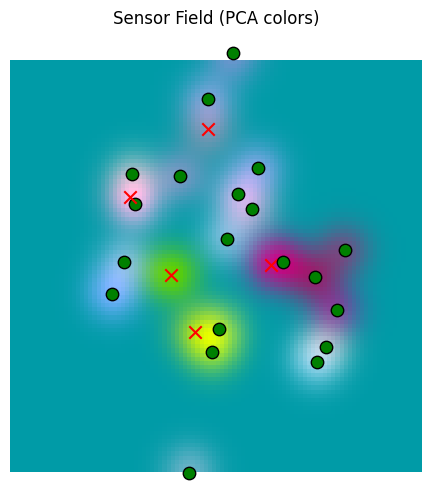

In [83]:
base_sensor_field, fig, ax = plot_sensor_field(sensor_values)

Now, let's create a memory and provide a way to show its contents.

In [84]:

from tree_world.models.memory import BidirectionalMemory

memory = BidirectionalMemory(
    location_dim=config.dim, 
    sensory_dim=config.sensory_embedding_dim, 
    embed_dim=config.embed_dim,   # note that if embed_dim=sensory_dim our memory does NOT compress or project inputs
    max_memory_size=1024,             # <-- beyond this size we will truncate the oldest memories
)


def plot_memory_field(train_locations: torch.Tensor, plot_locations: torch.Tensor, sd: float=1.0, match_threshold: float=None):
    # clear out the memory
    memory.reset()

    _, sensor_data, _ = sensor.sense(world, train_locations, None)

    # now we can call memory.write(locations, location_sds, senses) to write data
    train_location_sds = torch.empty_like(train_locations).fill_(sd)
    memory.write(train_locations, train_location_sds, sensor_data)

    # now we can call memory.read(locations, location_sds) to read data
    plot_location_sds = torch.empty_like(plot_locations).fill_(sd)
    read_data = memory.read(plot_locations[None, ...], plot_location_sds[None, ...], match_threshold=match_threshold)

    # plot the data
    plot_sensor_field(read_data.squeeze(0), key="Memory Field")

    return read_data.squeeze(0)

First, let's see how our memory does at just recalling the same data

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


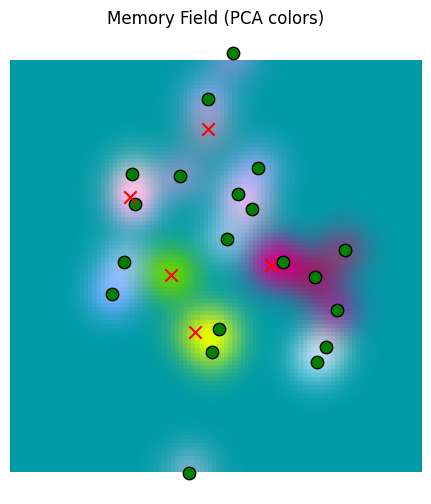

In [85]:
train_locations = make_2D_grid(points_per_axis=100)
read_data =plot_memory_field(train_locations, train_locations)

We can see here that the memory and the sensor yield plots appear virtually the same, so the memory is reading well. Just to be sure, we can compare them directly:

In [86]:
error = torch.norm(sensor_values - read_data, dim=-1)
print(f"Min Error: {error.min().item():.6f}")
print(f"Mean Error: {error.mean().item():.6f}")
print(f"Max Error: {error.max().item():.6f}")
print(f"Std Dev on Error: {error.std().item():.6f}")


Min Error: 0.000000
Mean Error: 0.000000
Max Error: 0.000000
Std Dev on Error: 0.000000


So the memory can read and write well. Now let's give it less data. Let's start with a smaller grid.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


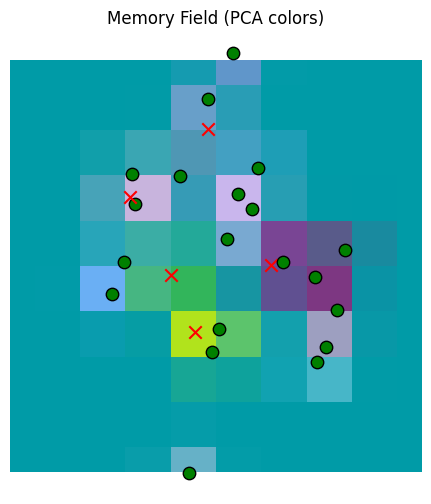

In [87]:
train_locations = make_2D_grid(points_per_axis=10)
plot_locations = make_2D_grid(points_per_axis=100)
smaller_grid_read_data = plot_memory_field(train_locations, plot_locations)

Our memory now provides a coarser approximation, as we expect. What if we provide random points, centered at the origin?

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


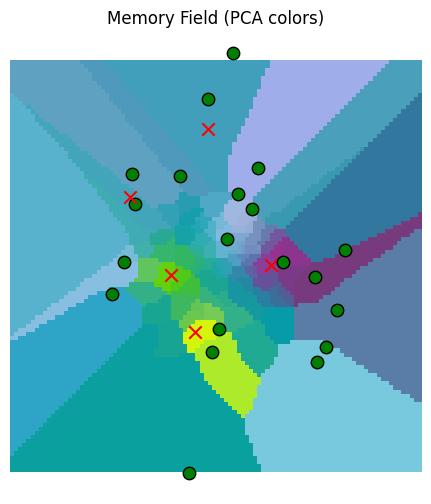

In [88]:
train_locations = torch.randn(100,2) * 100
plot_locations = make_2D_grid(points_per_axis=100)
gaussian_read_data = plot_memory_field(train_locations, plot_locations)

So the memory read quality is a good approximation near the origin, where it has more observations, but worse further away. This is all as we would expect. 

But still, do we really want to let points where we don't have good data be estimated from something far away? That doesn't make sense. That's why we snuck in the `match_threshold` parameter above, which lets us throw out approximants where there are no close points. You can look at `BidirectionalMemory.get_location_affinity()` for details, but basically we alter the read kernel to set $k(\ell, \ell_t) = 0$ if $\|\ell - \ell_t\| > \theta$ for the match threshold $\theta$.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


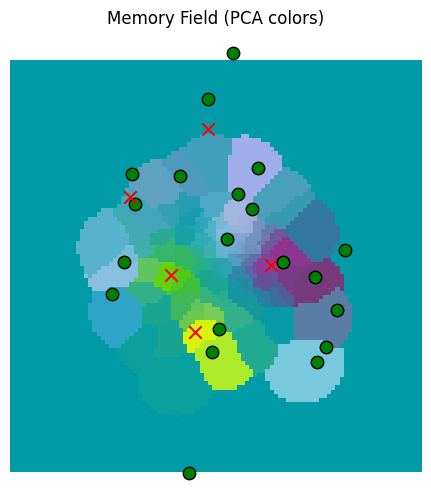

In [89]:
gaussian_read_data_thresholded = plot_memory_field(train_locations, plot_locations, match_threshold=100.0)

Much better now; we only make sensor estimates for values that are close.

## Classifying the Memory According to Drives

We are learning a location model that can predict senses from actions based on a memory. However, we also want to use that memory to search for where our agent can find fruit to satisfy its hunger. 

But to search the memory for things that satisfy hunger, we need to characterize sensory inputs in terms of the drives that they satisfy. So, we will build a _drive embedding classifier_ that takes classifies inputs across an array of mutually exclusive drives or motivations by computing
$$
s_m(z) = y_m \cdot z 
\quad\text{and evaluating}\quad 
\mathbb{P}(\text{$z$ satisfies $m$}) = \text{softmax}(s_m)
$$
which we train on the tree embeddings.

In [90]:
from tree_world.models.drives import train_drive_classifier

# we only want to train on the tree names (e.g. mango, pear, etc.), not the ids (Bob, Alice, etc.)
drive_classifier, drive_keys = train_drive_classifier(config, with_ids=False)
inverse_drive_keys = {v: k for k, v in drive_keys.items()}

print("--------------------------------")

tree_classifications = drive_classifier(torch.stack([tree.embedding for tree in world.trees]))
for tree, classification in zip(world.trees, tree_classifications):
    drive_idx = classification.argmax().item()
    drive = inverse_drive_keys[drive_idx]
    print(f"{tree.tree_id} -- {tree.name} -> {drive} ({classification[drive_idx].item()*100:.2f}%)")


Drive Embedding Classifier Loss (with fruit amount): 0.30447304248809814 MSE: 3.02012426800502e-06 Accuracy: 100.00%
--------------------------------
Ziggy -- manchineel -> poison (88.39%)
Theresa -- date -> edible (100.00%)
Richard -- desert rose -> poison (94.64%)
Xavier -- papaya -> edible (99.97%)
Charlie -- mango -> edible (100.00%)
Ziggy -- fig -> edible (100.00%)
Hal -- banana -> edible (100.00%)
Rachel -- apple -> edible (100.00%)
Jack -- papaya -> edible (100.00%)
Richard -- elderberry -> edible (99.99%)
Michael -- pear -> edible (100.00%)
Ulysses -- nectarine -> edible (100.00%)
Irene -- banana -> edible (100.00%)
Monica -- manchineel -> poison (57.83%)
Peter -- nightshade -> poison (87.02%)
Bill -- fig -> edible (100.00%)
Isaac -- strychnine fruit -> poison (90.41%)
Monica -- banana -> edible (100.00%)
Phoebe -- date -> edible (100.00%)
Oliver -- banana -> edible (100.00%)
Lisa -- nectarine -> edible (100.00%)
Ella -- plum -> edible (100.00%)
Uma -- banana -> edible (99.99%)

So our drive classifer correctly identifies the edible fruit.

Now let's visualize our sensor space in terms of drive satisfaction.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


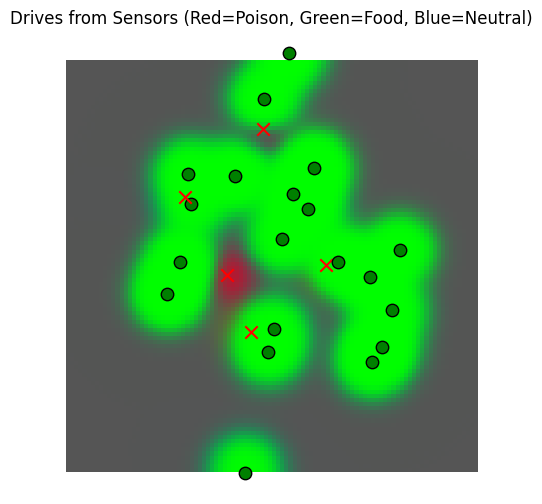

In [91]:


def plot_drive_field(values: torch.Tensor, key="Drives from Sensors", temperature=1.0):
    drive_by_location = drive_classifier(values)

    if temperature != 1.0:
        drive_by_location = drive_by_location ** (1.0 / temperature)
        drive_by_location = drive_by_location / drive_by_location.sum(dim=-1, keepdim=True)

    # we'll use a color scheme of red for poisonous, green for edible, and blue for unknown
    color_map = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=drive_by_location.dtype)
    color_by_location = torch.mm(drive_by_location, color_map).detach()

    H = W = int(math.sqrt(color_by_location.shape[0]))
    img = color_by_location.reshape(H, W, 3)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(
        img,
        extent=[-500, 500, -500, 500],  # [xmin, xmax, ymin, ymax]
        origin='lower',
        interpolation='nearest',
        aspect='equal',  # square pixels in world space
    )
    ax.set_title(f"{key} (Red=Poison, Green=Food, Blue=Neutral)")
    ax.axis("off")

    for tree in world.trees:
        x, y = tree.location.cpu().numpy()
        color = "red" if tree.is_poisonous else "green"
        ax.scatter(
            y, x,
            c=color, marker="x" if tree.is_poisonous else "o",
            s=80, edgecolor="k"
        )

    return img, fig

drive_field, fig = plot_drive_field(sensor_values)


We see that the sensors yield predictions of edible only around the trees, as expected, with poisonous food detected wherever there are not too many non-poisonous trees close by. 

Now let's see what happens if we use our memory. We'll use the memory made from Gaussian reads near the origin.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


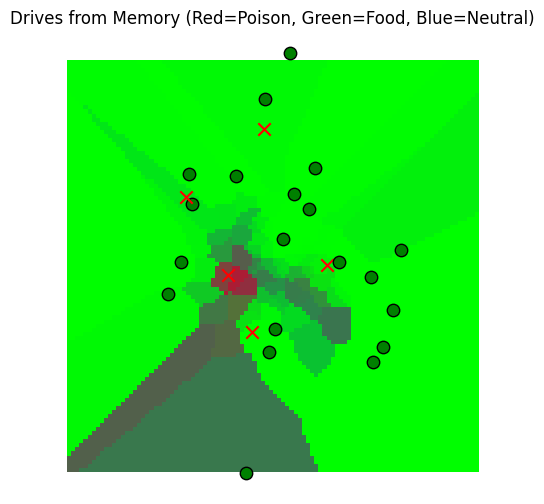

In [92]:
mem_drive_field, fig = plot_drive_field(gaussian_read_data, key="Drives from Memory")

Hmm, our memory is a little overactive. Maybe it's because of the way we chose to read based on the closest locations, even if they were far away in reality. To fix this, we should use the `match_threshold` parameter from above.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


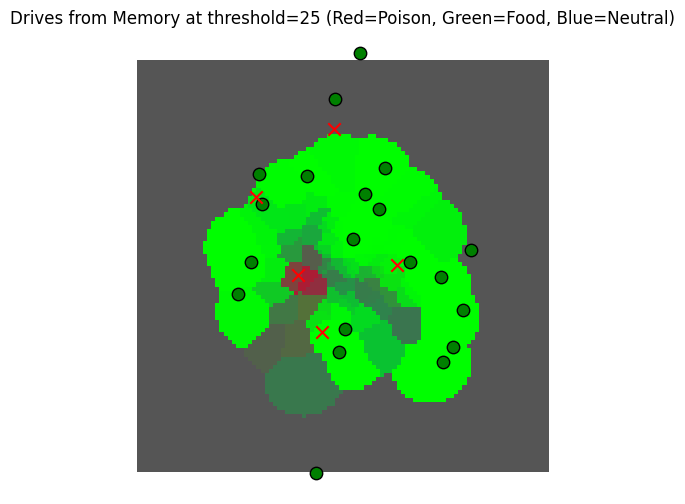

In [93]:
_, _ = plot_drive_field(gaussian_read_data_thresholded, key="Drives from Memory at threshold=25")


But this is still not really informative ... maybe it would be better to have a more peaked visualization to better observe the differences here.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


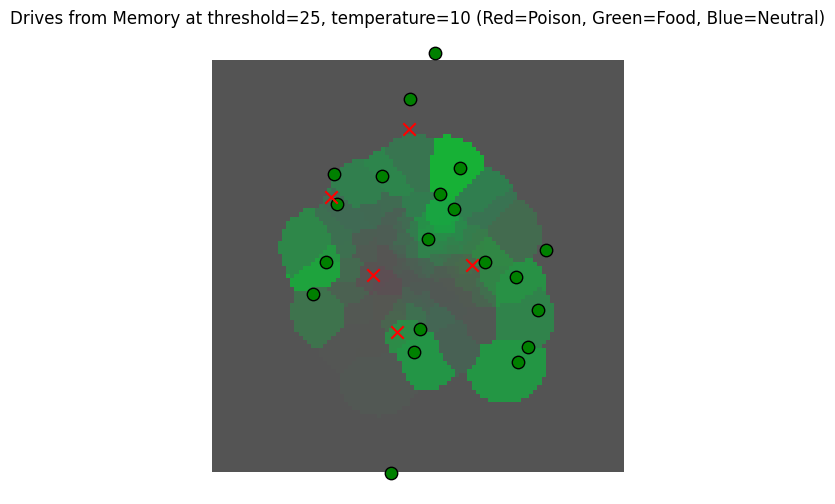

In [94]:
_, _ = plot_drive_field(gaussian_read_data_thresholded, key="Drives from Memory at threshold=25, temperature=10", temperature=10)

Now that we have a view of the memory based on drives, we can use it to find locations where there may be fruit.

## Searching the Memory for Information

We intend to use the memory three different ways:

- To read the expected sensory value of a location (as above)
- To verify an estimated location based on the sensory value (for learning the [Tolman Eichenbaum Machine] VAE)
- To find desirable sensory locations based on a goal (to satisfy the agent's needs)

The first usage can be modeled as a regression over prior observations, as we did above. The second usage can ALSO be realized as a regression IF the sensor results are sufficiently distinctive. That is, so long as distinct locations ($\ell_t \neq \ell_s$) lead to distinct observations ($\implies z_t \neq z_s$), then we could apply the same regression-based read as before with the values swapped ($\hat{\ell} = g(z)$).

The second usage can be subsumed into the third, where we interpret the "goal" as being the current sensory observation.

The third usage requires something different from the first; in general, the basic drives of the organism will not be unique. So each non-poisonous fruit tree will satisfy hunger, and hence we no longer want a strict _function_ (one input -> one output). Instead, we want to _search_ the memory to provide multiple possible matches for a query value. 

Since our memory does not contain exact values for us to retrieve in any case, it will suffice to think of this search as a _sampling_ problem. That is, we want to use our observation dataset to learn a distribution that we can flexibly sample to get locations likely to satisfy our goal. 

Now, to specify what "meeting our goal" is. Let us suppose we have a scoring function $s(z)$ for sensor observations that assigns large positive values to matches, zero to ambiguous possible matches, and large negative numbers to irrelevant or mismatched data. 

So we want a conditional probability distribution $\mathbb{Q}$ over $\ell$ such that $$\hat{\ell} \sim \mathbb{Q}\left(\ell \,\vert\, s\right) \quad\implies\quad s\left(f(\hat{\ell})\right) >\!> 0$$
Which is to say that our samples are well aligned with our search key.

Now, for the simplest case, we can suppose there is a search key $y$, which will be a vector in the same space as our sensory output $z$, so that we can define the _affinity_ of $z$ to $y$ via dot products $s(z) = y \cdot z$. This gives us a straightforward way to compute the affinity of previously observed locations to our search; we just need to figure out $y$.

Because we already built a drive classifier for our sensors, we can use this classifier to get our affinity. For hunger, we can choose the sensor $s_{\text{hunger}}$ from the definition of the classifier above, which is determined by a search key $y_{\text{hunger}}$. Let's print it out.

In [95]:
y_hunger = drive_classifier.drive_embeddings.weight[drive_keys["edible"]].data
print(f"y_hunger = {y_hunger}")

value_of_apple =(world.tree_name_embeddings["apple"] * y_hunger).pow(2).sum().item()
print(f"value of apple for hunger = {value_of_apple} >> 0")


y_hunger = tensor([ 0.6639, -0.2142,  1.1718,  ...,  0.3519, -0.0972,  0.7220])
value of apple for hunger = 1.473150610923767 >> 0


So, we can find the edible fruit by sampling over our memory using $y_{\text{hunger}}$ as a search key.

But what does _sampling_ in this case mean? And how can we sample efficiently?

As a first approach, it is fairly simple to sample using a Gaussian mixture model (GMM). A GMM is just weighted sum of Gaussians:
$$
p_{\text{mix}}(z) \propto \sum_t w_t \,\mathcal{N}(z_t, \sigma^2)
$$
where $\mathcal{N}$ is just the Gaussian kernel and the weights are a softmax over the alignment scores,
$$
w_t = \text{softmax}_t \left(s(z_t)\right) = \text{softmax}_t \left(z_t \cdot y_{\text{hunger}}\right)
$$
To sample from this mixture, we first sample from $w_t$ as a multinomial, and then we use the resulting $z_t$ as the centroid of Gaussian with covariance $\sigma^2 I$.

In [96]:
def sample_conditional_gmm(memory_locations: torch.Tensor, memory_location_sds: torch.Tensor, memory_values: torch.Tensor, 
                           search_key: torch.Tensor, sigma_scale: float=25.0, num_samples: int=1, temperature: float=None):
    # memory_locations has shape (..., num_observations, dim)
    # memory_values has shape (..., num_observations, embed_dim)
    # search_key has shape (..., embed_dim)

    if temperature is None:
        temperature = memory_values.shape[-1]**(-0.5)

    # compute the alignment scores
    s_t = torch.bmm(memory_values, search_key[..., None]).squeeze(-1)
    w_t = torch.softmax(temperature * s_t, dim=-1)

    # sample from the mixture, result will be (..., num_samples)
    t = torch.multinomial(w_t, num_samples=num_samples, replacement=True)
    t = t.unsqueeze(-1).repeat(1, 1, memory_locations.shape[-1])
    loc_mean = memory_locations.gather(dim=-2, index=t)
    loc_sd = memory_location_sds.gather(dim=-2, index=t)
    return loc_mean + torch.randn_like(loc_mean) * sigma_scale * loc_sd

# take a sample
hunger_sample = sample_conditional_gmm(
    memory.memory_locations, memory.memory_location_sds, memory.memory_senses, y_hunger[None, ...], num_samples=250,
    temperature=1.0
).squeeze(0)
hunger_sample_deviation = torch.norm(hunger_sample - hunger_sample.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {hunger_sample.shape} with deviation {hunger_sample_deviation}")

_, sensor_data_at_samples, _ = sensor.sense(world, hunger_sample, None)

drives_at_samples = drive_classifier(sensor_data_at_samples)

avg_hunger_at_samples = drives_at_samples[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples = drives_at_samples[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples}")
print(f"Minimum hunger at samples: {min_hunger_at_samples}")


Got a sample of shape torch.Size([250, 2]) with deviation 59.38222885131836
Average hunger at samples: 0.9982703924179077
Minimum hunger at samples: 0.9422715306282043


So we get a sample that has a high match with the hunger drive, as expected. But it looks like our samples are clustered too tightly! Where are our samples?

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


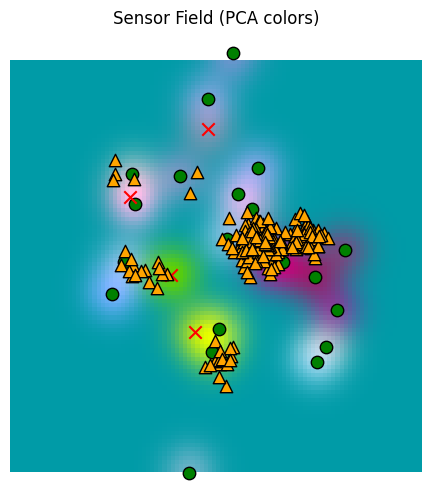

In [97]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in hunger_sample:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

Well, these samples are ok, but they aren't really representative enough. We need to raise the temperature of our softmax. Here, I've set the default for `temperature` to be $1 / \sqrt{d}$, matching the kernel typically used for dot product attention. Let's use that instead of `temperature=1`.

In [98]:
# take a sample
hunger_sample_temperature = sample_conditional_gmm(
    memory.memory_locations, memory.memory_location_sds, memory.memory_senses, y_hunger[None, ...], num_samples=250,
    sigma_scale=25.0,
    temperature=None # <-- default; uses 1 / sqrt(d)
).squeeze(0)
hunger_sample_deviation = torch.norm(hunger_sample_temperature - hunger_sample_temperature.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {hunger_sample_temperature.shape} with deviation {hunger_sample_deviation}")

_, sensor_data_at_samples_temperature, _ = sensor.sense(world, hunger_sample_temperature, None)

drives_at_samples_temperature = drive_classifier(sensor_data_at_samples_temperature)

avg_hunger_at_samples_temperature = drives_at_samples_temperature[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples_temperature = drives_at_samples_temperature[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples_temperature}")
print(f"Minimum hunger at samples: {min_hunger_at_samples_temperature}")

Got a sample of shape torch.Size([250, 2]) with deviation 64.5694580078125
Average hunger at samples: 0.8289923071861267
Minimum hunger at samples: 0.121449314057827


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


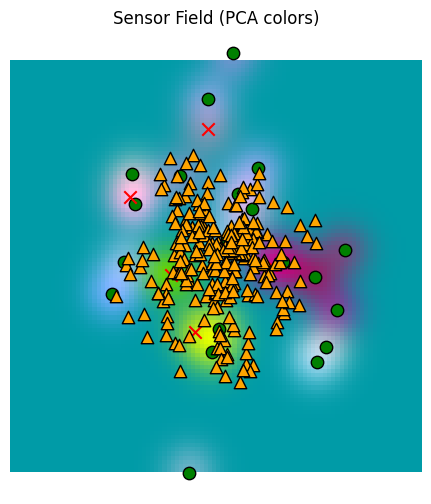

In [99]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in hunger_sample_temperature:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

Much better. Recall that the memory was populated from a Gaussian set of original locations, explaining why the samples are clustered about the origin and don't reach the edges of the space.

Note that our minimum hunger value has dropped significantly, though. We get more diverse samples, but they may have lower quality overall.

Yet we need to go further. For our agent, we don't just want to find a match for our drive anywhere; we want to preference matches that are close to the agent's current position.

We'll accomplish this by adjusting $w_t$ to take a given location $\ell$ into account:
$$
w_t = \textrm{softmax}\left(s_t \times \log k(\ell, \ell_t)\right)
$$

In [100]:
def sample_conditional_gmm_with_location(
    memory_locations: torch.Tensor, memory_location_sds: torch.Tensor, memory_values: torch.Tensor, 
    search_key: torch.Tensor, search_location: torch.Tensor, search_location_sd: torch.Tensor, 
    sigma_scale: float=1.0, num_samples: int=1, temperature: float=None
):
    # memory_locations has shape (..., num_observations, dim)
    # memory_values has shape (..., num_observations, embed_dim)
    # search_key has shape (..., embed_dim)

    if temperature is None:
        temperature = memory_values.shape[-1]**(-0.5)

    # compute the alignment scores
    s_t = torch.bmm(memory_values, search_key[..., None]).squeeze(-1)

    # compute the combined variance, which has shape (..., num_queries, num_keys)
    variance = search_location_sd**2 + memory_location_sds**2
    log_k = (
        - 0.5 * ((search_location - memory_locations).pow(2) / variance).sum(dim=-1) 
        - torch.log(variance).sum(dim=-1)
        - 0.5 * math.log(2 * math.pi) * variance.shape[-1]
    )

    w_t = torch.softmax(temperature * s_t * log_k, dim=-1)

    # sample from the mixture, result will be (..., num_samples)
    t = torch.multinomial(w_t, num_samples=num_samples, replacement=True)
    t = t.unsqueeze(-1).repeat(1, 1, memory_locations.shape[-1])
    loc_mean = memory_locations.gather(dim=-2, index=t)
    loc_sd = memory_location_sds.gather(dim=-2, index=t)
    return loc_mean + torch.randn_like(loc_mean) * sigma_scale * loc_sd

# take a sample
location = torch.tensor([[100.0, 100.0]])
location_sd = torch.tensor([[25.0, 25.0]])
hunger_sample_with_location = sample_conditional_gmm_with_location(
    memory.memory_locations, memory.memory_location_sds, memory.memory_senses, y_hunger[None, ...], location, location_sd,
    num_samples=250, sigma_scale=25.0, temperature=None # <-- default; uses 1 / sqrt(d)
).squeeze(0)
hunger_sample_deviation_with_location = torch.norm(hunger_sample_with_location - hunger_sample_with_location.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {hunger_sample_with_location.shape} with deviation {hunger_sample_deviation_with_location}")

_, sensor_data_at_samples_with_location, _ = sensor.sense(world, hunger_sample_with_location, None)

drives_at_samples_with_location = drive_classifier(sensor_data_at_samples_with_location)

avg_hunger_at_samples_with_location = drives_at_samples_with_location[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples_with_location = drives_at_samples_with_location[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples_with_location}")
print(f"Minimum hunger at samples: {min_hunger_at_samples_with_location}")

Got a sample of shape torch.Size([250, 2]) with deviation 56.322265625
Average hunger at samples: 0.6643033623695374
Minimum hunger at samples: 0.11692565679550171


Here we've biased the search to locations just up and to the right of the origin (marked with a blue square below). When this is done, we get a set of samples (yellow triangles) that is noticeably different from the free sampling above. 

Unlike when we were reading the memory above, we do NOT want to restrict match locations (`match_locations` above) when we are trying to find candidates to resolve drives. If we did that, we would exclude all faraway locations, and the only satisfaction might actually be far away. So we want to allow the memory search farther afield, if needed.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


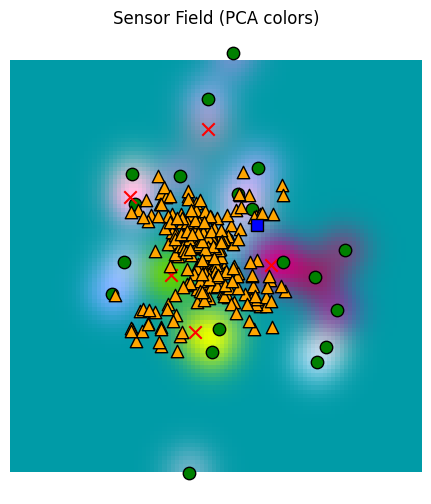

In [101]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in hunger_sample_with_location:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

ax.scatter(location[0, 0], location[0, 1], c="blue", marker="s", s=80, edgecolor="k")

This last sample function is also implemented, with a few more bells and whistles, on the `memory` object:

In [102]:
sample_hunger_from_memory = memory.sample(
    location, location_sd, y_hunger[None, ...], num_samples=250, sigma_scale=25.0, temperature=1.0 # <-- uses 1 / sqrt(d) here!!!
).squeeze( )

hunger_sample_from_memory_deviation = torch.norm(sample_hunger_from_memory - sample_hunger_from_memory.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {sample_hunger_from_memory.shape} with deviation {hunger_sample_from_memory_deviation}")

_, sensor_data_at_samples_from_memory, _ = sensor.sense(world, sample_hunger_from_memory, None)

drives_at_samples_from_memory = drive_classifier(sensor_data_at_samples_from_memory)

avg_hunger_at_samples_from_memory = drives_at_samples_from_memory[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples_from_memory = drives_at_samples_from_memory[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples_from_memory}")
print(f"Minimum hunger at samples: {min_hunger_at_samples_from_memory}")



Got a sample of shape torch.Size([250, 2]) with deviation 25.25982666015625
Average hunger at samples: 0.9779053926467896
Minimum hunger at samples: 0.5152919888496399


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


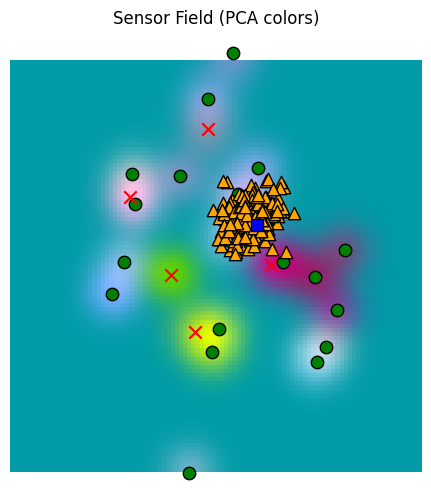

In [103]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in sample_hunger_from_memory:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

ax.scatter(location[0, 0], location[0, 1], c="blue", marker="s", s=80, edgecolor="k")

## Pruning the memory

If we insert observation tuples $(\ell_t, \sigma_t, z_t)$ every time step, our memory will fill up very quickly. 

Let $M$ be the total number of entries into memory. Practically speaking, with current hardware we can easily read and search up to $M=512$ without any specialized hardware, and with a good GPU we can get to $M=4096$ if we only need a few frames per second. With some optimization, we could extend that up towards $M=32,768$ with flash attention, and with low-dimensional vectors we can potentially go even higher. But just because we could doesn't mean we should. If a robot operates at 10 cycles per second (roughly the speed of the human cortex alpha waves), then a memory with $M=4,096$ would be exhausted in 410 seconds -- less than 7 minutes. Not much of a memory.

Given that the goal is to model $\hat{z} = f(\ell, \sigma)$, remembering everything is computationally wasteful as well, since many of the observation points are close together and overlap. So it makes sense to optimize a little bit. Here are some options:

- Update instead of insert at write time, if points are close enough together.
- Learn a simple regressor for $f$ periodically and discard the old memory entirely
- Periodically prune the memory and/or reposition observation points 

Updating at write time is feasible, but interrupts the main behavioral cycle. `BidirectionalMemory` has an `update` parameter that does exactly this, but it's not a systematic way to manage the memory, and probably is not the best option.

Learning another regressor would do well for reading, and for small datasets of a few thousand or tens of thousands of points, it can be done in parallel to the behavioral loop. But a model for sampling would need to be learned as well. Furthermore, if we run this regression at time $t$ and it finishes at time $t + \Delta t$, then we have to remember the observations that happen during $\Delta t$. It could be complicated to integrate the two, unless the new regressor is just a new sequence of observation points with the same read and sample behavior as above.

Which brings us to the final option, either pruning or reconfiguring the observation points periodically. This can be done in parallel to running a policy that depends on the memory: the policy would simple access the memory as usual from time $t$ until the update is ready at time $t + \Delta t$. Then it would remove the observations up to time $t$, replacing them with the reduced set, but keeping the observations between $t$ and $\Delta t$.

Formally, let $O[s:t] = \left\{\left.(\tau, \ell_\tau, \sigma_\tau, z_\tau) \,\right\vert\, s \leq \tau < t\right\}$ be the observations between times $s$ and $t$, not including $t$. The pruning / reconfiguration process generates a new set of virtual observations
$$
V = \left\{\left.(r, \ell_r, \sigma_r, z_r) \,\right\vert\, 0 \leq r \leq R\right\}
\quad\text{such that}\quad
f(\ell, \sigma; O[0:t]) \approx f(\ell, \sigma; V)
$$
where $R <\!< t$ and $f(\ell, \sigma; A)$ indicates the memory read function $f$ applied to memory contents $A$. Then, when $V$ is ready at time $t + \Delta t$, the observation set used by the agent is hot-swapped from $O[0:t+\Delta t]$ to  $V \cup O[t:t+\Delta t]$, preserving all new observations.

To begin to prune, we can estimate the importance of each observation by reading from the memory with that observation removed. This can be done by computing $\log k(\ell_s, \ell_t)$ and masking the diagonal before reading.

In [104]:
def read_one_removed(memory_locations: torch.Tensor, memory_deviation: torch.Tensor, 
                     memory_values: torch.Tensor, match_threshold: float=None) -> torch.Tensor:
    # we expect memory_locations to be a tensor of shape (..., num_keys, dim)
    # we expect memory_deviation to be a tensor of shape (..., num_keys, dim)
    # we expect memory_values to be a tensor of shape (..., num_keys, embed_dim)

    memory_loc_q = memory_locations[..., None, :, :]
    memory_loc_k = memory_locations[..., None, :]

    memory_loc_sd_q = memory_deviation[..., None, :, :]
    memory_loc_sd_k = memory_deviation[..., None, :]
    
    # compute the combined variance, which has shape (..., num_queries, num_keys)
    variance = memory_loc_sd_q**2 + memory_loc_sd_k**2
    location_delta = memory_loc_q - memory_loc_k
    log_k = (
        - 0.5 * (location_delta.pow(2) / variance).sum(dim=-1) 
        - torch.log(variance).sum(dim=-1)
        - 0.5 * math.log(2 * math.pi) * variance.shape[-1]
    )

    # make a mask to zero out the diagonal
    diag_mask = torch.eye(log_k.shape[-2], device=log_k.device, dtype=torch.bool)
    while diag_mask.ndim < log_k.ndim:
        diag_mask = diag_mask[None, ...]

    # zero out the diagonal
    log_k = log_k.masked_fill(diag_mask, -float('inf'))

    if match_threshold is not None:
        threshold_check = torch.norm(location_delta, dim=-1) > match_threshold
        log_k = log_k.masked_fill(threshold_check, float('-inf'))

    # the location affinity weights have shape (..., num_queries, num_keys)
    w = torch.softmax(log_k, dim=-1)
    
    # we have to account for the case where there are no nearby matches
    inactive = (log_k <= float('-inf')).all(dim=-1)
    w = torch.where(inactive[..., None], torch.zeros_like(log_k), w)

    hat_z = torch.bmm(w, memory_values)

    error = torch.norm(hat_z - memory_values, dim=-1)

    dependencies = w > (1 / memory_values.shape[-2])

    return hat_z, error, dependencies


# let's fill up our memory with random locations, more than before
memory.reset()
locations = torch.randn(1, 1024, 2) * 100
location_sds = torch.full_like(locations, 10.0)
_, sensory, _ = sensor.sense(world, locations.squeeze(0), None)
print(f"Writing {locations.shape} observations to memory")
memory.write(locations, location_sds, sensory[None, ...])

z_leave_one_out, error_leave_one_out, dependencies_leave_one_out = read_one_removed(
    memory.memory_locations, memory.memory_location_sds, memory.memory_senses, match_threshold=25.0
)

print(f"Memory size: {memory.memory_locations.shape[1]}")
print()
print(f"Min error of leave-one-out read: {error_leave_one_out.min().item()}")
print(f"Mean error of leave-one-out read: {error_leave_one_out.mean().item()}")
print(f"Max error of leave-one-out read: {error_leave_one_out.max().item()}")
print(f"Std dev of leave-one-out error: {error_leave_one_out.std().item()}")

dependencies_per_slot = dependencies_leave_one_out.float().sum(dim=-1).squeeze()
print()
print(f"Min dependencies per slot: {dependencies_per_slot.min().item()}")
print(f"Mean dependencies per slot: {dependencies_per_slot.mean().item()}")
print(f"Max dependencies per slot: {dependencies_per_slot.max().item()}")
print(f"Std dev of dependencies per slot: {dependencies_per_slot.std().item()}")


Writing torch.Size([1, 1024, 2]) observations to memory
Memory size: 1024

Min error of leave-one-out read: 0.0038309581577777863
Mean error of leave-one-out read: 0.16315118968486786
Max error of leave-one-out read: 5.8697991371154785
Std dev of leave-one-out error: 0.40229126811027527

Min dependencies per slot: 0.0
Mean dependencies per slot: 15.048828125
Max dependencies per slot: 36.0
Std dev of dependencies per slot: 9.421878814697266


So, there are items whose removal is ignorable (the min error, typically < 0.01), and other items that are isolated (min dependencies=0) and cannot be removed.

We can start by removing the non-isolated items with the lowest error. When doing so, we want to be careful not to remove two items that were depending on each other; then we might have worse error than projected.

Let's see how many we can prune that way.

In [105]:
def generate_prune_candidates(
    error_leave_one_out: torch.Tensor, dependencies_leave_one_out: torch.Tensor, max_error_to_prune: float=0.05
):
    # remove candidates that are a dependency of another candidate with a lower error
    sorted_error, error_indices = torch.sort(error_leave_one_out, dim=-1)
    unsort_indices = torch.argsort(error_indices, dim=-1)

    dependencies = dependencies_leave_one_out.gather(
        dim=-2, index=error_indices[..., None].repeat(1, 1, dependencies_leave_one_out.shape[-1])
    ).gather(
        dim=-1, index=error_indices[..., None, :].repeat(1, dependencies_leave_one_out.shape[-1], 1)
    )

    # generate a list of all candidates, ignoring dependencies
    candidates = sorted_error < max_error_to_prune

    # remove candidates with zero dependencies
    num_dependencies = dependencies.long().sum(dim=-1)
    candidates = candidates & (num_dependencies > 0)

    # remove candidates that are a dependency of another candidate with a lower error
    dependencies_mask = torch.tril(dependencies, diagonal=-1).any(dim=-1)
    candidates = candidates & dependencies_mask

    return candidates.gather(dim=-1, index=unsort_indices) 


prune_candidates_005 = generate_prune_candidates(error_leave_one_out, dependencies_leave_one_out, max_error_to_prune=0.05)
prune_candidates_005 = prune_candidates_005.squeeze().nonzero()
print()
print("Prune candidates at 0.05: ", prune_candidates_005.cpu().numpy().tolist())
print("Number of items to prune at 0.05: ", prune_candidates_005.shape[0])

prune_candidates_001 = generate_prune_candidates(error_leave_one_out, dependencies_leave_one_out, max_error_to_prune=0.01)
prune_candidates_001 = prune_candidates_001.squeeze().nonzero()
print()
print("Prune candidates at 0.01: ", prune_candidates_001.cpu().numpy().tolist())
print("Number of items to prune at 0.01: ", prune_candidates_001.shape[0])





Prune candidates at 0.05:  [[3], [14], [15], [18], [21], [22], [23], [27], [28], [43], [46], [51], [52], [53], [59], [64], [70], [72], [75], [76], [79], [81], [83], [96], [97], [102], [104], [112], [114], [115], [117], [131], [141], [148], [150], [151], [152], [153], [158], [159], [160], [165], [170], [175], [176], [187], [188], [191], [194], [195], [211], [212], [213], [215], [219], [222], [227], [230], [233], [234], [236], [240], [245], [246], [250], [261], [263], [264], [268], [275], [280], [282], [288], [292], [293], [294], [298], [303], [311], [312], [313], [321], [322], [328], [333], [335], [345], [352], [358], [362], [363], [365], [366], [369], [371], [374], [382], [386], [391], [392], [399], [403], [404], [405], [409], [412], [413], [416], [425], [433], [436], [440], [442], [443], [444], [447], [454], [456], [459], [462], [471], [472], [473], [475], [477], [483], [484], [491], [493], [498], [505], [510], [511], [514], [517], [522], [524], [528], [530], [545], [546], [550], [55

So then, there are 5-15 items out of 1024 that we safely prune with an error threshold of 0.01, and if we are willing to allow higher error, there are a few hundred.

Further, we can apply this recursively until none are removed. Let's do the pruning.

In [106]:
starting_memory_locations = memory.memory_locations.clone()
starting_memory_location_sds = memory.memory_location_sds.clone()
starting_memory_senses = memory.memory_senses.clone()

starting_memory_result = memory.read(plot_locations[None, ...], torch.full_like(plot_locations[None, ...], 10.0), match_threshold=25.0)


def prune_memory(memory_locations: torch.Tensor, memory_location_sds: torch.Tensor, memory_senses: torch.Tensor, 
                 max_error_to_prune: float=0.05, match_threshold: float=25.0):
    _, error_leave_one_out, dependencies_leave_one_out = read_one_removed(
        memory_locations, memory_location_sds, memory_senses, match_threshold=match_threshold
    )
    prune_candidates = generate_prune_candidates(error_leave_one_out, dependencies_leave_one_out, max_error_to_prune)

    # decide what to prune
    mem_size = prune_candidates.shape[-1]
    prune_size = mem_size -prune_candidates.long().sum(dim=-1).max().item()
    scores = mem_size - prune_candidates.float() * torch.arange(prune_candidates.shape[-1], device=prune_candidates.device)[None, ...]

    _, pruned_indices = torch.topk(scores, k=prune_size, dim=-1)

    pruned_indices_loc = pruned_indices[..., None].repeat(1, 1, memory_locations.shape[-1])
    pruned_indices_sense = pruned_indices[..., None].repeat(1, 1, memory_senses.shape[-1])

    pruned_memory_locations = memory_locations.gather(dim=-2, index=pruned_indices_loc)
    pruned_memory_location_sds = memory_location_sds.gather(dim=-2, index=pruned_indices_loc)
    pruned_memory_senses = memory_senses.gather(dim=-2, index=pruned_indices_sense)

    num_pruned = prune_candidates.sum(dim=-1)

    return num_pruned, pruned_memory_locations, pruned_memory_location_sds, pruned_memory_senses


def recursive_prune_memory(memory_locations: torch.Tensor, memory_location_sds: torch.Tensor, memory_senses: torch.Tensor, 
                           max_error_to_prune: float=0.05, match_threshold: float=25.0, max_prune_steps: int=10):
    for _ in range(max_prune_steps):
        num_pruned, memory_locations, memory_location_sds, memory_senses = prune_memory(memory_locations, memory_location_sds, memory_senses, max_error_to_prune, match_threshold)
        print(f"Pruned removed items: {num_pruned.detach().cpu().numpy().tolist()}")
        if num_pruned.max().item() == 0:
            break

    return memory_locations, memory_location_sds, memory_senses

pruned_memory_locations, pruned_memory_location_sds, pruned_memory_senses = recursive_prune_memory(
    starting_memory_locations, starting_memory_location_sds, starting_memory_senses, 
    max_error_to_prune=0.05, match_threshold=25.0, max_prune_steps=10
)

memory.memory_locations = pruned_memory_locations
memory.memory_location_sds = pruned_memory_location_sds
memory.memory_senses = pruned_memory_senses

print(f"Final memory size: {pruned_memory_locations.shape[1]}")

pruned_memory_result = memory.read(plot_locations[None, ...], torch.full_like(plot_locations[None, ...], 10.0), match_threshold=25.0)


Pruned removed items: [285]
Pruned removed items: [103]
Pruned removed items: [49]
Pruned removed items: [17]
Pruned removed items: [10]
Pruned removed items: [5]
Pruned removed items: [3]
Pruned removed items: [2]
Pruned removed items: [0]
Final memory size: 550


So we've pruned our memory almost in half. But now how bad is our error? Let's compare to sensor data and to the prior data

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


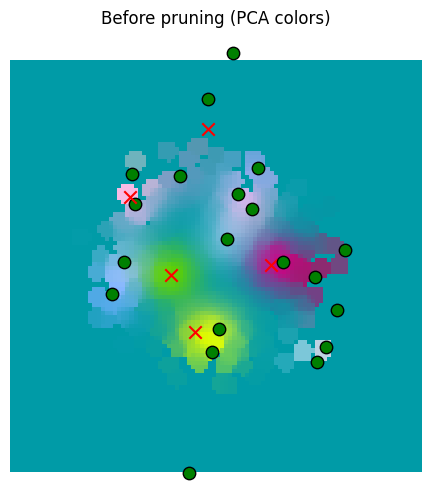

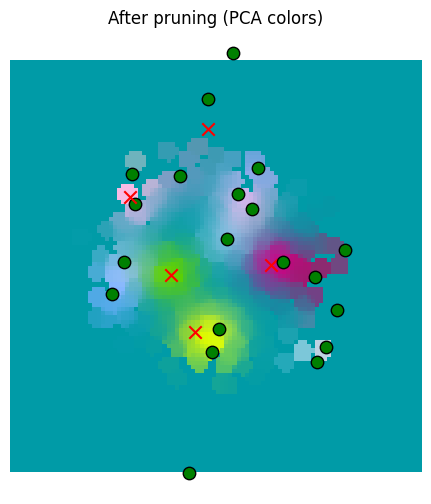

In [107]:
_ = plot_sensor_field(starting_memory_result.squeeze(0), key="Before pruning")
_ = plot_sensor_field(pruned_memory_result.squeeze(0), key="After pruning")


It's hard to see a difference, but surely there must be one, right? Let's check the numbers and plot the diff.

In [108]:
error_after_pruning = torch.norm(pruned_memory_result - starting_memory_result, dim=-1)

print(f"Min error (vs. memory read prior) after pruning: {error_after_pruning.min().item()}")
print(f"Mean error (vs. memory read prior) after pruning: {error_after_pruning.mean().item()}")
print(f"Max error (vs. memory read prior) after pruning: {error_after_pruning.max().item()}")
print(f"Std dev of error (vs. memory read prior) after pruning: {error_after_pruning.std().item()}")

error_vs_sensor_prior = torch.norm(starting_memory_result - sensor_values[None, ...], dim=-1)
print()
print(f"Min error (vs. sensor) prior: {error_vs_sensor_prior.min().item()}")
print(f"Mean error (vs. sensor) prior: {error_vs_sensor_prior.mean().item()}")
print(f"Max error (vs. sensor) prior: {error_vs_sensor_prior.max().item()}")
print(f"Std dev of error (vs. sensor) prior: {error_vs_sensor_prior.std().item()}")

error_vs_sensor_after_pruning = torch.norm(pruned_memory_result - sensor_values[None, ...], dim=-1)
print()
print(f"Min error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.min().item()}")
print(f"Mean error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.mean().item()}")
print(f"Max error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.max().item()}")
print(f"Std dev of error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.std().item()}")







Min error (vs. memory read prior) after pruning: 0.0
Mean error (vs. memory read prior) after pruning: 0.009783104993402958
Max error (vs. memory read prior) after pruning: 1.0762475728988647
Std dev of error (vs. memory read prior) after pruning: 0.043581459671258926

Min error (vs. sensor) prior: 2.699658015689701e-21
Mean error (vs. sensor) prior: 0.3306715190410614
Max error (vs. sensor) prior: 5.8749518394470215
Std dev of error (vs. sensor) prior: 0.7294334769248962

Min error (vs. sensor) after pruning: 2.699658015689701e-21
Mean error (vs. sensor) after pruning: 0.33465561270713806
Max error (vs. sensor) after pruning: 5.8749518394470215
Std dev of error (vs. sensor) after pruning: 0.7286837100982666


So in some cases there is significant error, but the distribution of errors vs. the underlying sensor data is basically unaffected.

Let's plot the diff.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


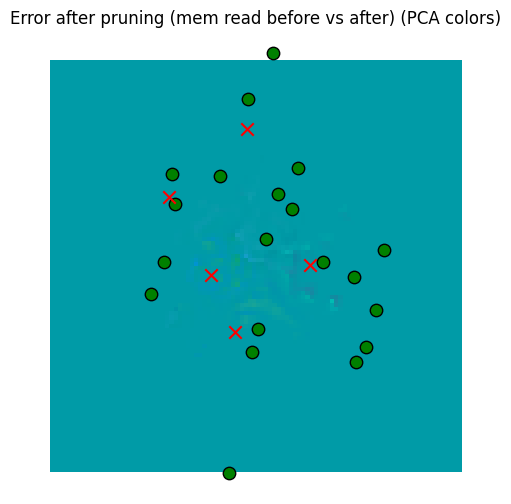

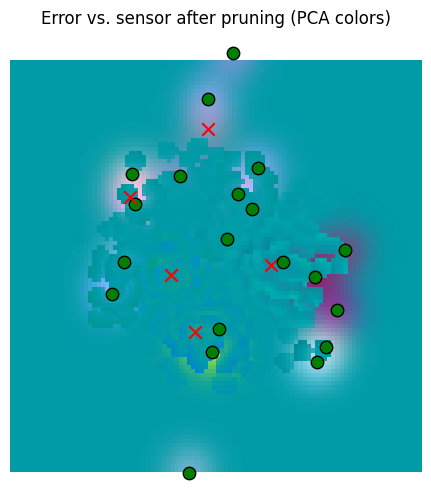

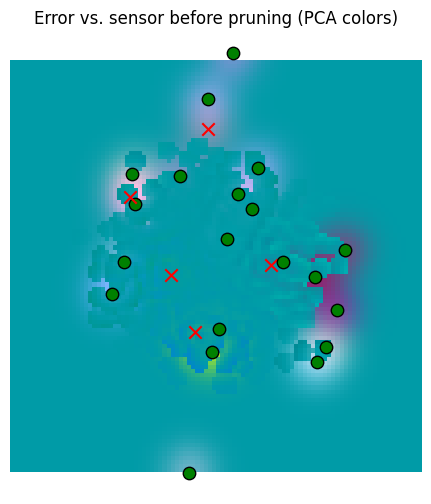

In [109]:
_ = plot_sensor_field((pruned_memory_result - starting_memory_result).squeeze(0), key="Error after pruning (mem read before vs after)")
_ = plot_sensor_field((sensor_values[None, ...] - pruned_memory_result).squeeze(0), key="Error vs. sensor after pruning")
_ = plot_sensor_field((sensor_values[None, ...] - starting_memory_result).squeeze(0), key="Error vs. sensor before pruning")






So yes, there's error, but that error is dwarfed by the error against the sensory data. So our aggressive pruning was probably beneficial.

But we can also regress on the prior memory values to move around the prune values a bit, which should help with this error.

In [110]:
class MemoryRegressor(torch.nn.Module):
    def __init__(self, memory: BidirectionalMemory, memory_locations: torch.Tensor, memory_location_sds: torch.Tensor, 
                 memory_senses: torch.Tensor):
        super().__init__()
        self.memory = memory
        self.memory_locations = torch.nn.Parameter(memory_locations)
        self.memory_location_sds = torch.nn.Parameter(memory_location_sds)
        self.memory_senses = torch.nn.Parameter(memory_senses)

    def forward(self, locations: torch.Tensor, location_sds: torch.Tensor):
        self.memory.memory_locations = self.memory_locations
        self.memory.memory_location_sds = self.memory_location_sds
        self.memory.memory_senses = self.memory_senses

        return self.memory.read(locations, location_sds, match_threshold=25.0, detach_senses=False, detach_locations=False)

regressor = MemoryRegressor(memory, pruned_memory_locations, pruned_memory_location_sds, pruned_memory_senses)
optimizer = torch.optim.Adam(regressor.parameters(), lr=0.001)

steps = 100
for i in range(steps):
    optimizer.zero_grad()
    pruned_memory_result = regressor(plot_locations[None, ...], torch.full_like(plot_locations[None, ...], 10.0))
    error = torch.norm(pruned_memory_result - starting_memory_result, dim=-1).pow(2).mean()
    if i % 10 == 0:
        print(f"Step {i} error: {error.item()}")
    error.backward()
    optimizer.step()

memory.memory_locations = regressor.memory_locations
memory.memory_location_sds = regressor.memory_location_sds
memory.memory_senses = regressor.memory_senses

pruned_memory_result_regressed = memory.read(
    plot_locations[None, ...], torch.full_like(plot_locations[None, ...], 10.0), match_threshold=25.0
)

error_after_pruning = torch.norm(pruned_memory_result_regressed - starting_memory_result, dim=-1)

print(f"Min error (vs. memory read prior) after pruning: {error_after_pruning.min().item()}")
print(f"Mean error (vs. memory read prior) after pruning: {error_after_pruning.mean().item()}")
print(f"Max error (vs. memory read prior) after pruning: {error_after_pruning.max().item()}")
print(f"Std dev of error (vs. memory read prior) after pruning: {error_after_pruning.std().item()}")

error_vs_sensor_prior = torch.norm(starting_memory_result - sensor_values[None, ...], dim=-1)
print()
print(f"Min error (vs. sensor) prior: {error_vs_sensor_prior.min().item()}")
print(f"Mean error (vs. sensor) prior: {error_vs_sensor_prior.mean().item()}")
print(f"Max error (vs. sensor) prior: {error_vs_sensor_prior.max().item()}")
print(f"Std dev of error (vs. sensor) prior: {error_vs_sensor_prior.std().item()}")

error_vs_sensor_after_pruning = torch.norm(pruned_memory_result_regressed - sensor_values[None, ...], dim=-1)
print()
print(f"Min error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.min().item()}")
print(f"Mean error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.mean().item()}")
print(f"Max error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.max().item()}")
print(f"Std dev of error (vs. sensor) after pruning: {error_vs_sensor_after_pruning.std().item()}")

Step 0 error: 0.00199486268684268
Step 10 error: 0.0010215683141723275
Step 20 error: 0.0008367904811166227
Step 30 error: 0.0007604383281432092
Step 40 error: 0.0007189279422163963
Step 50 error: 0.0006930520758032799
Step 60 error: 0.0006745554856024683
Step 70 error: 0.0006602004286833107
Step 80 error: 0.0006486601778306067
Step 90 error: 0.0006386636523529887
Min error (vs. memory read prior) after pruning: 0.0
Mean error (vs. memory read prior) after pruning: 0.005573210772126913
Max error (vs. memory read prior) after pruning: 1.0762475728988647
Std dev of error (vs. memory read prior) after pruning: 0.02456561103463173

Min error (vs. sensor) prior: 2.699658015689701e-21
Mean error (vs. sensor) prior: 0.3306715190410614
Max error (vs. sensor) prior: 5.8749518394470215
Std dev of error (vs. sensor) prior: 0.7294334769248962

Min error (vs. sensor) after pruning: 2.699658015689701e-21
Mean error (vs. sensor) after pruning: 0.33248311281204224
Max error (vs. sensor) after pruning:

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_77027/1373293567.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


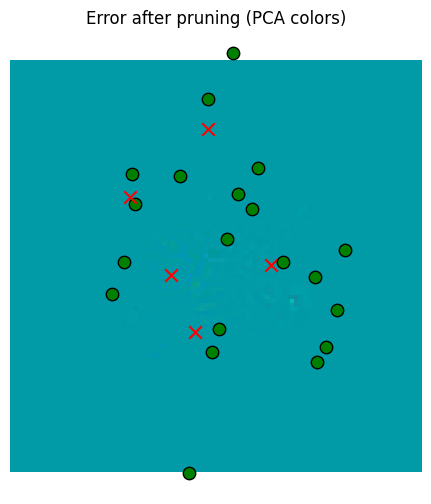

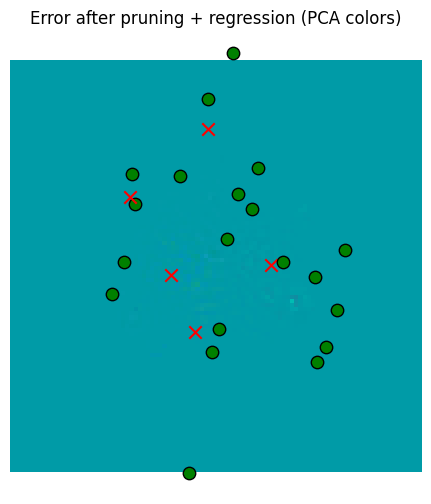

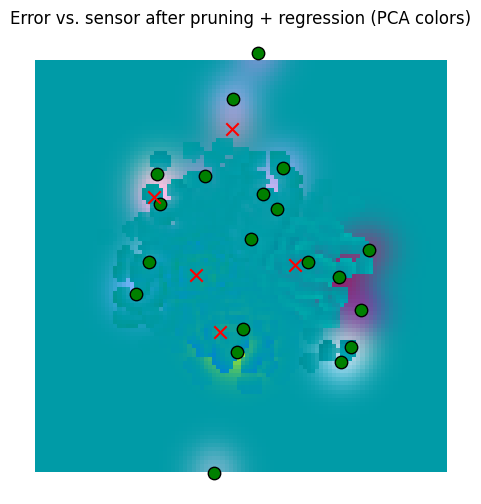

In [111]:
_ = plot_sensor_field((pruned_memory_result - starting_memory_result).squeeze(0), key="Error after pruning")
_ = plot_sensor_field((pruned_memory_result_regressed - starting_memory_result).squeeze(0), key="Error after pruning + regression")
_ = plot_sensor_field((sensor_values[None, ...] - pruned_memory_result_regressed).squeeze(0), key="Error vs. sensor after pruning + regression")

So in the end, regressing gives us a little extra, but in the context of memory read error vs. the sensors, it's probably not worth it. Pruning alone, however, is very valuable for computational reasons.

`BidirectionalMemory` implements `prune()` but does not regress at present.

In [112]:
memory = BidirectionalMemory(
    max_memory_size=1024,
    location_dim=config.dim,
    sensory_dim=config.sensory_embedding_dim,
    embed_dim=config.embed_dim,
)

locations = torch.randn(1, 1024, 2) * 100
location_sds = torch.full_like(locations, 10.0)
_, sensory, _ = sensor.sense(world, locations.squeeze(0), None)
print(f"Writing {locations.shape} observations to memory")
memory.write(locations, location_sds, sensory[None, ...])

print(f"Before pruning, memory has {memory.memory_locations.shape[1]} items")
memory.prune(max_error_to_prune=0.05, match_threshold=25.0, max_prune_steps=10)
print(f"After pruning, memory has {memory.memory_locations.shape[1]} items")


Writing torch.Size([1, 1024, 2]) observations to memory
Before pruning, memory has 1024 items
After pruning, memory has 548 items


# Conclusion

That wraps it up for the memory; we can

- Insert sensory data by location and retrieve results across the location space
- Read locations based on a sensory input and a location guess
- Sample locations that potentially can satisfy a drive
- Prune the memory to reduce memory and computation

Now we will use these capabilities to build an agent that learns latent locations spaces while seeking to satisfy drives!